In [97]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.executable)
import socket
print(socket.gethostname())
import os
os.chdir("/home/icb/alioguz.can/projects/4i_tests")
sys.path.append("/home/icb/alioguz.can/projects/4i_tests/cellseg")

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/icb/alioguz.can/miniconda3/envs/he_env/bin/python
gpusrv26.scidom.de


In [98]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import squidpy as sq
import seaborn  as sns

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: VL Whole Slide Microscopy Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 2.16.840.1
(0002,0013) Implementation Version Name         SH: 'SAM_1_2_0'
(0002,0016) Source Application Entity Title     AE: 'Segue_SCU'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'VOLUME', 'RESAMPLED']
(0008,0016) SOP Class UID                       UI: VL Whole Slide Microscopy Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147
(

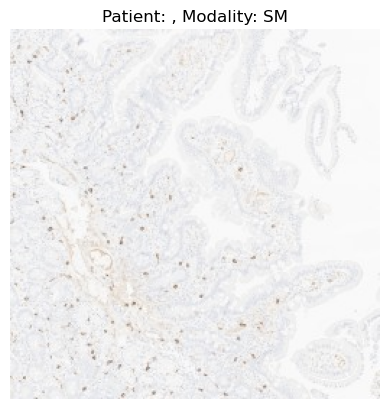

In [242]:
# Load DICOM file
dicom_path = "/home/icb/alioguz.can/projects/he_pathalogy/1.3.6.1.4.1.36533.1592234914724322466371556613121619813816147.dcm"

ds = pydicom.dcmread(dicom_path)

# Show metadata
print(ds)

# Extract pixel data as numpy array
image = ds.pixel_array.astype(float)

# Normalize image for display
image = (np.maximum(image, 0) / image.max()) * 255.0
image = np.uint8(image)

# Plot
plt.imshow(image[150])
plt.title(f"Patient: {ds.PatientName}, Modality: {ds.Modality}")
plt.axis("off")
plt.show()

[debug] neutrality scores -> candA: 0.000, candB: 44.667
(3131, 4332, 3) uint8 60 255


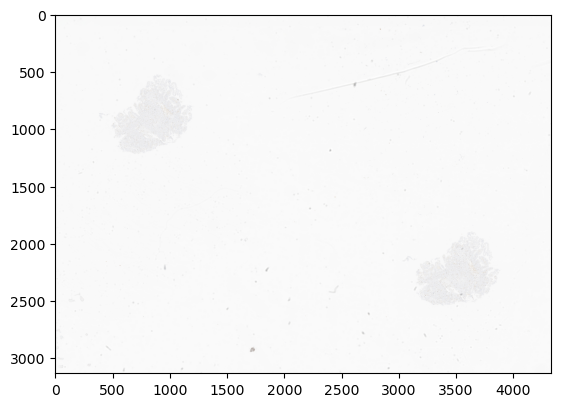

In [248]:
# One-cell, no-saving, auto-fix for the "everything looks pink" issue.
# It stitches tiles, then **auto-detects** whether ds.pixel_array is already RGB
# (some JPEG decoders return RGB even if PhotometricInterpretation says YBR_FULL_422).
# It tries BOTH: (A) as-is, (B) YBR->RGB converted, then (optionally) applies ICC to sRGB,
# and picks the version whose bright background has the most neutral (R≈G≈B) stats.

import io
import numpy as np
import pydicom
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import convert_color_space
from PIL import Image, ImageCms
import matplotlib.pyplot as plt

def _apply_icc_to_srgb(arr_rgb_uint8, icc_bytes):
    """Apply embedded ICC profile to sRGB; return np.uint8 RGB. If anything fails, return original."""
    if icc_bytes is None:
        return arr_rgb_uint8
    try:
        src = ImageCms.ImageCmsProfile(io.BytesIO(icc_bytes))
        dst = ImageCms.createProfile("sRGB")
        img = Image.fromarray(arr_rgb_uint8, mode="RGB")
        xform = ImageCms.buildTransform(src, dst, "RGB", "RGB", intent=0)
        out = ImageCms.applyTransform(img, xform)
        return np.asarray(out, dtype=np.uint8)
    except Exception as e:
        print(f"[warn] ICC transform failed; using uncorrected RGB. Reason: {e}")
        return arr_rgb_uint8

def _neutral_background_score(arr_rgb):
    """
    Lower is better. Heuristic:
      - focus on bright pixels (top 10% by luminance)
      - compute median absolute channel deviation from their mean per-pixel
    """
    if arr_rgb.size == 0:
        return np.inf
    arr = arr_rgb.reshape(-1, 3).astype(np.float32)
    Y = 0.2126*arr[:,0] + 0.7152*arr[:,1] + 0.0722*arr[:,2]
    if len(Y) < 1000:
        idx = np.arange(len(Y))
    else:
        thresh = np.quantile(Y, 0.90)
        idx = np.nonzero(Y >= thresh)[0]
        if idx.size < 500:
            idx = np.argsort(Y)[-500:]
    s = arr[idx]
    mean_rgbs = s.mean(axis=1, keepdims=True)
    dev = np.abs(s - mean_rgbs)
    return float(np.median(dev))

def _stitch(ds, tiles_rgb_uint8):
    """Place tiles onto Total Pixel Matrix according to PlanePositionSlideSequence."""
    H = int(ds[(0x0048, 0x0007)].value)  # Total Pixel Matrix Rows
    W = int(ds[(0x0048, 0x0006)].value)  # Total Pixel Matrix Columns
    th, tw = int(ds.Rows), int(ds.Columns)
    n = int(ds.NumberOfFrames)
    canvas = np.zeros((H, W, 3), dtype=np.uint8)

    pffgs = ds.get((0x5200, 0x9230))  # PerFrameFunctionalGroupsSequence
    if pffgs:
        for i in range(n):
            plane_pos = pffgs[i].PlanePositionSlideSequence[0]
            r0 = int(plane_pos.RowPositionInTotalImagePixelMatrix)
            c0 = int(plane_pos.ColumnPositionInTotalImagePixelMatrix)
            r1 = min(r0 + th, H); c1 = min(c0 + tw, W)
            h = r1 - r0; w = c1 - c0
            if h > 0 and w > 0:
                canvas[r0:r1, c0:c1] = tiles_rgb_uint8[i, :h, :w]
    else:
        # Fallback raster (rare for VL WSI but kept for completeness)
        per_row = (W + tw - 1) // tw
        for i in range(n):
            rr, cc = divmod(i, per_row)
            r0, c0 = rr*th, cc*tw
            r1 = min(r0 + th, H); c1 = min(c0 + tw, W)
            canvas[r0:r1, c0:c1] = tiles_rgb_uint8[i, :r1-r0, :c1-c0]
    return canvas

def reconstruct_wsi_rgb_auto(dicom_path, apply_icc=True, debug=False):
    ds = dcmread(str(dicom_path), force=True)

    # Decode frames once
    frames = ds.pixel_array  # shape: (N, h, w, 3) but color space may already be RGB depending on decoder
    if frames.dtype != np.uint8:
        frames = frames.astype(np.uint8, copy=False)

    # Candidate A: assume frames are already RGB
    candA = _stitch(ds, frames)

    # Candidate B: if declared YBR, try converting and stitch
    photometric = str(ds.PhotometricInterpretation).upper()
    candB = None
    if photometric in ("YBR_FULL_422", "YBR_FULL"):
        try:
            frames_ybr2rgb = convert_color_space(frames, photometric, "RGB")
            if frames_ybr2rgb.dtype != np.uint8:
                frames_ybr2rgb = frames_ybr2rgb.astype(np.uint8, copy=False)
            candB = _stitch(ds, frames_ybr2rgb)
        except Exception as e:
            if debug: print(f"[debug] YBR->RGB convert failed: {e}")

    # Score both (lower is better neutrality in bright background)
    if candB is None:
        chosen = candA
        if debug: print("[debug] Only candA available; selecting candA.")
    else:
        sA = _neutral_background_score(candA)
        sB = _neutral_background_score(candB)
        if debug: print(f"[debug] neutrality scores -> candA: {sA:.3f}, candB: {sB:.3f}")
        chosen = candA if sA <= sB else candB

    # Optional ICC to sRGB (Leica embeds a large ICC profile)
    icc_bytes = None
    if (0x0028, 0x2000) in ds and ds[(0x0028, 0x2000)].value:
        icc_bytes = ds[(0x0028, 0x2000)].value
    if apply_icc and icc_bytes is not None:
        chosen = _apply_icc_to_srgb(chosen, icc_bytes)

    return chosen

# ==== Run (no saving) ====
# dicom_path = "/path/to/your/leica_wsi.dcm"
# If you've already set dicom_path earlier in the notebook, this will use it:
merged_arr = reconstruct_wsi_rgb_auto(dicom_path, apply_icc=True, debug=True)
print(merged_arr.shape, merged_arr.dtype, merged_arr.min(), merged_arr.max())

plt.figure()
plt.imshow(merged_arr)
plt.show()

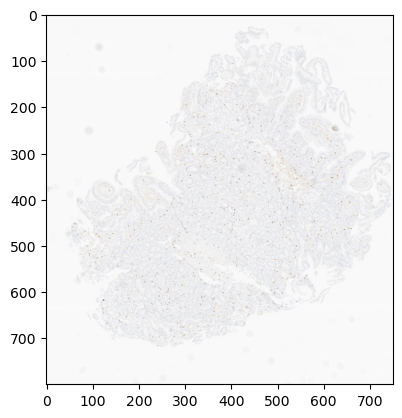

In [258]:
plt.imshow(merged_arr[500:1300, 450:1200])

tmp=merged_arr[500:1300, 450:1200]

In [118]:
test_tile = image[150]
print(test_tile.shape)

(256, 256, 3)


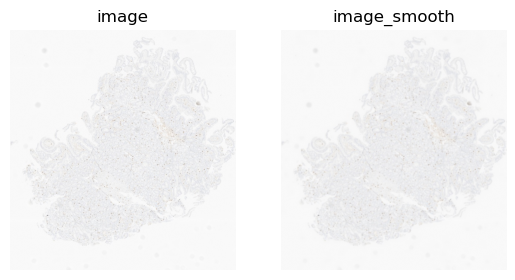

In [259]:
test_tile_cont = tmp[None,:,:,:]
sq_imgCont = sq.im.ImageContainer(test_tile_cont, layer="image", mask=None, dims="channels_last")
# smooth image
sq.im.process(sq_imgCont, layer="image", method="smooth", sigma=1)

# plot the result
fig, axes = plt.subplots(1, 2)
for layer, ax in zip(["image", "image_smooth"], axes):
    sq_imgCont.show(layer, ax=ax)
    ax.set_title(layer)

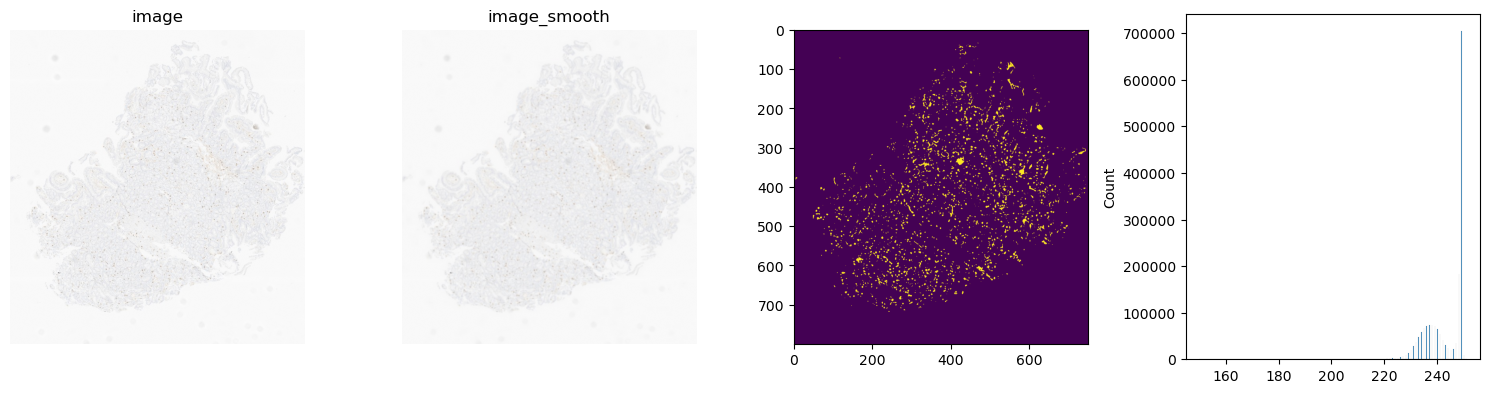

In [263]:
def show_histogram(sq_imgCont, threshold_value=230, bins=50):
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    sq_imgCont.show("image", cmap="gray", ax=axes[0])
    sq_imgCont.show("image_smooth", cmap="gray", ax=axes[1])
    axes[2].imshow(sq_imgCont["image_smooth"][:, :, 0, 0] < threshold_value)
    _ = sns.histplot(np.array(sq_imgCont["image_smooth"]).flatten(), bins=bins, ax=axes[3])
    plt.tight_layout()
    
show_histogram(sq_imgCont, threshold_value=230, bins=500)

ImageContainer[shape=(800, 750), layers=['image', 'image_smooth', 'segmented_watershed']]
Number of segments in crop: 544
Number of objects identified: 543


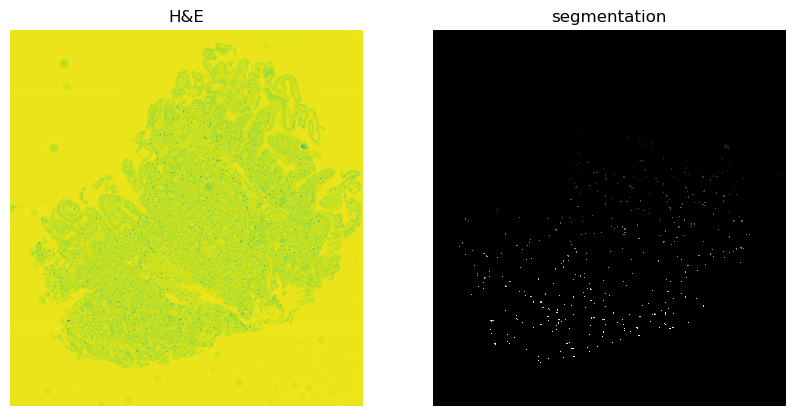

In [265]:
sq.im.segment(img=sq_imgCont, layer="image_smooth", method="watershed", thresh=220, geq=False)
print(sq_imgCont)
print(f"Number of segments in crop: {len(np.unique(sq_imgCont['segmented_watershed']))}")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sq_imgCont.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("H&E")
sq_imgCont.show("segmented_watershed", cmap="gray", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")
# segmentation mask inside the Squidpy ImageContainer
seg_mask = sq_imgCont["segmented_watershed"].values
# unique labels (0 = background)
labels = np.unique(seg_mask)
n_objects = len(labels) - (1 if 0 in labels else 0)
print(f"Number of objects identified: {n_objects}")